## Handling Missing Data

Real-world datasets are rarely complete. Missing values arise for many reasons — including data collection errors, non-responses, system limitations, or simply unavailable measurements. Since most machine learning algorithms cannot handle missing data directly, proper data preparation becomes a critical step in any data science workflow.

In this section, we will explore practical approaches to detecting, understanding, and handling missing data using Python, with a focus on Pandas and Scikit-learn. We begin by identifying missing values and examining common missing-data mechanisms:

- **Missing Completely At Random (MCAR)** — when the probability of missingness is independent of both observed and unobserved data.
- **Missing At Random (MAR)** — when missingness depends only on observed variables.
- **Missing Not At Random (MNAR)** — when missingness depends on the unobserved value itself.

We then move to practical imputation strategies. These include simple techniques such as mean, median, and mode imputation, as well as the creation of missing-value indicator features that preserve information about where data was originally missing.

Throughout this section, hands-on examples and exercises will reinforce the concepts and demonstrate how to apply these techniques in real data science workflows.

### References

- https://apxml.com/courses/intro-feature-engineering/
- https://www.youtube.com/watch?v=h2dOKH5aLFg
- https://tmb.njtierney.com/missing-data-dependence#missing-completely-at-random-mcar
---

## Identifying Missing Values

Identifying where missing data occurs within a dataset is a fundamental step in data preparation. Incomplete data can compromise model training, leading to errors, biased estimates, or reduced predictive performance. Before applying any imputation strategy, we must first understand **where**, **how much**, and **in which variables** missingness occurs.

Fortunately, the Pandas library provides efficient and intuitive tools for detecting and quantifying missing entries.

---

### Standard Missing Data Representation in Pandas

Pandas primarily represents missing values using:

- **`NaN` (Not a Number)** — the standard representation for missing numerical data (based on NumPy).
- **`None`** — often used in object-type columns (e.g., strings), though it is internally treated similarly to `NaN`.
- **`pd.NA`** — a more recent, unified missing value indicator introduced to support nullable data types.

Understanding how missing values are encoded is essential, since detection methods rely on these representations.

---

In [65]:
import pandas as pd
import numpy as np

data = {'col_a': [1, 2, np.nan, 4, 5],
        'col_b': [np.nan, 'x', 'y', 'z', 'x'],
        'col_c': [True, False, True, np.nan, False],
        'col_d': [10.1, 20.2, 30.3, np.nan, 50.5]}
df = pd.DataFrame(data)

print(df)

   col_a col_b  col_c  col_d
0    1.0   NaN   True   10.1
1    2.0     x  False   20.2
2    NaN     y   True   30.3
3    4.0     z    NaN    NaN
4    5.0     x  False   50.5


## Detecting Missing Values with `isnull()` and `isna()`

Pandas provides two essentially equivalent methods — **`isnull()`** and **`isna()`** — to detect missing values in a dataset. Both functions return a boolean object (Series or DataFrame) with the same shape as the original data, where:

- **`True`** indicates a missing value (`NaN`, `None`, or `pd.NA`)
- **`False`** indicates a valid (non-missing) entry

In practice, the two methods are interchangeable. The `isna()` name aligns more closely with NumPy conventions, while `isnull()` reflects terminology commonly used in database systems. Choosing one over the other is mostly a matter of stylistic preference, but consistency within a project is recommended.

---

In [66]:
missing_mask = df.isnull()
print(missing_mask)

   col_a  col_b  col_c  col_d
0  False   True  False  False
1  False  False  False  False
2   True  False  False  False
3  False  False   True   True
4  False  False  False  False


In [67]:
missing_mask = df.isna()
print(missing_mask)

   col_a  col_b  col_c  col_d
0  False   True  False  False
1  False  False  False  False
2   True  False  False  False
3  False  False   True   True
4  False  False  False  False


In [68]:
present_mask = df.notnull()
print(present_mask)

   col_a  col_b  col_c  col_d
0   True  False   True   True
1   True   True   True   True
2  False   True   True   True
3   True   True  False  False
4   True   True   True   True


In [69]:
present_mask = df.notna()
print(present_mask)

   col_a  col_b  col_c  col_d
0   True  False   True   True
1   True   True   True   True
2  False   True   True   True
3   True   True  False  False
4   True   True   True   True


## Summarizing Missing Data Counts

While a boolean mask produced by `isna()` or `isnull()` is useful for locating missing values, in practice we often need **aggregate statistics** to better understand the extent of missingness in a dataset.

Because boolean values are treated numerically in Python (`True = 1`, `False = 0`), we can chain aggregation methods such as `.sum()` after `isna()` (or `isnull()`) to count missing entries.

---

In [70]:
# Count missing values per column
missing_counts = df.isnull().sum()
print(missing_counts)

col_a    1
col_b    1
col_c    1
col_d    1
dtype: int64


In [71]:
# Calculate percentage of missing values per column
missing_percentage = (df.isnull().sum() / len(df)) * 100
print(missing_percentage)

col_a    20.0
col_b    20.0
col_c    20.0
col_d    20.0
dtype: float64


In [72]:
# Count total missing values in the DataFrame
total_missing = df.isnull().sum().sum()
print(f"Total missing values: {total_missing}")

Total missing values: 4


## Visualizing Missing Data Patterns

Numerical summaries of missing data are essential, but visualizations often provide a more intuitive understanding of **missing-data structure and patterns**. Visual inspection can reveal clustering, systematic gaps, or relationships between missingness across variables that may not be obvious from summary statistics alone.

A common approach is to visualize the boolean mask generated by `isna()` (or `isnull()`). Heatmaps are particularly useful for this purpose and are typically created using visualization libraries such as **Matplotlib** or **Seaborn**.

Another effective strategy is to display a **bar chart showing the count or percentage of missing values per feature**, which quickly highlights problematic variables.

---

In [73]:
#complement df with more rows to make the visualization more meaningful
data = {'col_a': [1, 2, np.nan, 4, 5, 6, 7, np.nan, 9, 10],
        'col_b': [np.nan, 'x', 'y', 'z', 'x', 'y', 'z', 'x', 'y', np.nan],
        'col_c': [True, False, True, True, False, True, False, True, np.nan, False],
        'col_d': [10.1, 20.2, 30.3, None, 50.5, 60.6, None, None, 90.9, np.nan]}
df = pd.DataFrame(data)
df

,col_a,col_b,col_c,col_d
0,1.0,NaN,True,10.1
1,2.0,x,False,20.2
2,NaN,y,True,30.3
3,4.0,z,True,NaN
4,5.0,x,False,50.5
5,6.0,y,True,60.6
6,7.0,z,False,NaN
7,NaN,x,True,NaN
8,9.0,y,NaN,90.9
9,10.0,NaN,False,NaN


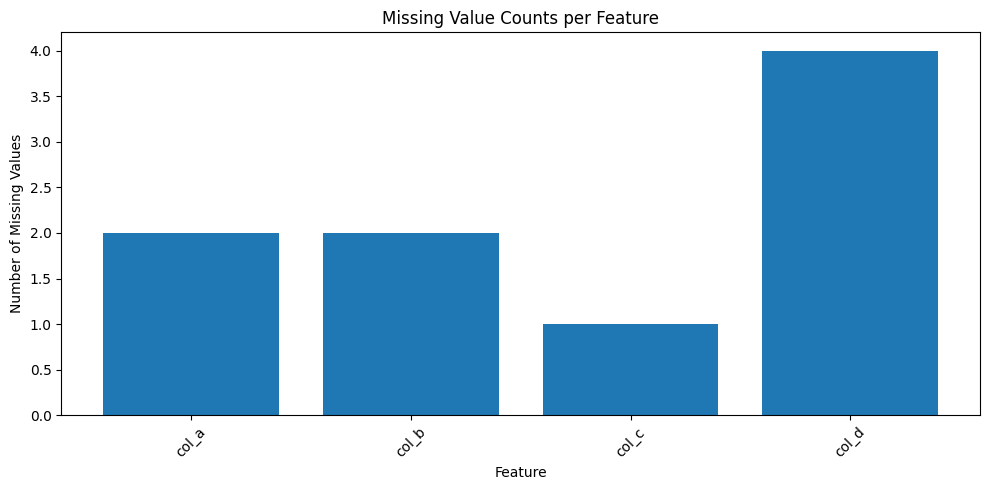

In [74]:
import matplotlib.pyplot as plt

missing_counts = df.isnull().sum()

plt.figure(figsize=(10,5))
#plt.bar(x,height) where x is the index (feature names) and height is the count of missing values
plt.bar(missing_counts.index, missing_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Feature")
plt.ylabel("Number of Missing Values")
plt.title("Missing Value Counts per Feature")
plt.tight_layout()
plt.show()

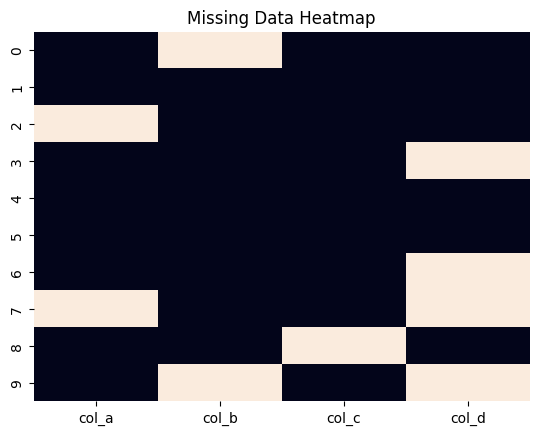

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

## Handling Non-Standard Missing Value Representations

Not all datasets encode missing values using standard markers such as `NaN`, `None`, or `pd.NA`. In many real-world cases, missing data may appear as placeholder strings (e.g., `"?"`, `"Unknown"`, `"N/A"`, `"None"`) or as sentinel numeric values (e.g., `999`, `-1`, or other unlikely measurements).

These non-standard representations must be explicitly converted into recognized missing-value markers; otherwise, Pandas will treat them as valid data, which can lead to incorrect analyses or misleading model behavior.

---

### Specifying Missing Markers When Loading Data

When importing data with Pandas (for example, using `pd.read_csv()`), you can define custom missing-value indicators using the `na_values` parameter:

In [76]:
# Assume df_dirty contains '?' instead of NaN in 'col_b'
df_dirty = pd.DataFrame({
    'col_a': [1, 2, np.nan],
    'col_b': [10, '?', 30]
})

print("Before replacement:")
print(df_dirty)
print("\nMissing counts before:")
print(df_dirty.isnull().sum())

# Replace '?' with NaN
df_clean = df_dirty.replace('?', np.nan)

print("\nAfter replacement:")
print(df_clean)
print("\nMissing counts after:")
print(df_clean.isnull().sum())

Before replacement:
   col_a col_b
0    1.0    10
1    2.0     ?
2    NaN    30

Missing counts before:
col_a    1
col_b    0
dtype: int64

After replacement:
   col_a col_b
0    1.0    10
1    2.0   NaN
2    NaN    30

Missing counts after:
col_a    1
col_b    1
dtype: int64


In [77]:
#read auto1.tsv and count missing values in each column
df_auto = pd.read_csv('auto-mpg.csv')
missing_counts = df_auto.isnull().sum()
df_auto.info()
#horsepower column has 6 missing values, which are represented as '?', so we need to specify that when reading the data


<class 'pandas.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    str    
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    str    
dtypes: float64(3), int64(4), str(2)
memory usage: 28.1 KB


In [78]:
#run all elements in horsepower column and check if any of them are '?'
print(df_auto['horsepower'].unique())

<StringArray>
['130', '165', '150', '140', '198', '220', '215', '225', '190', '170', '160',
  '95',  '97',  '85',  '88',  '46',  '87',  '90', '113', '200', '210', '193',
   '?', '100', '105', '175', '153', '180', '110',  '72',  '86',  '70',  '76',
  '65',  '69',  '60',  '80',  '54', '208', '155', '112',  '92', '145', '137',
 '158', '167',  '94', '107', '230',  '49',  '75',  '91', '122',  '67',  '83',
  '78',  '52',  '61',  '93', '148', '129',  '96',  '71',  '98', '115',  '53',
  '81',  '79', '120', '152', '102', '108',  '68',  '58', '149',  '89',  '63',
  '48',  '66', '139', '103', '125', '133', '138', '135', '142',  '77',  '62',
 '132',  '84',  '64',  '74', '116',  '82']
Length: 94, dtype: str


In [79]:
for value in df_auto['horsepower']:
    if value == '?':
        print("Found a '?' in horsepower column")

Found a '?' in horsepower column
Found a '?' in horsepower column
Found a '?' in horsepower column
Found a '?' in horsepower column
Found a '?' in horsepower column
Found a '?' in horsepower column


In [80]:
#print sum of missing data
missing_counts = df_auto.isnull().sum()
print(missing_counts)

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


In [81]:
#read the data again, but this time specify that '?' should be treated as NaN
df_auto = pd.read_csv('auto-mpg.csv', na_values='?')
missing_counts = df_auto.isnull().sum()

In [82]:
missing_counts = df_auto.isnull().sum()
print(missing_counts)

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


If the data is already loaded, you can use the .replace() method to convert these placeholders to np.nan, allowing isnull() to detect them correctly:

In [83]:
df_auto = pd.read_csv('auto-mpg.csv')
missing_counts = df_auto.isnull().sum()
df_auto.info()

<class 'pandas.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    str    
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    str    
dtypes: float64(3), int64(4), str(2)
memory usage: 28.1 KB


In [84]:
#use replace method to convert '?' to np.nan in horsepower column
df_auto['horsepower'] = df_auto['horsepower'].replace('?', np.nan)
missing_counts = df_auto.isnull().sum()
df_auto.info()

<class 'pandas.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    str    
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    str    
dtypes: float64(3), int64(4), str(2)
memory usage: 28.1 KB


In [85]:
#convert horsepower column to numeric, which will convert any remaining non-numeric values to NaN
df_auto['horsepower'] = pd.to_numeric(df_auto['horsepower'])
df_auto.info()

<class 'pandas.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    str    
dtypes: float64(4), int64(4), str(1)
memory usage: 28.1 KB


## Mechanisms of Missing Data (MCAR, MAR, MNAR)

Before applying any imputation technique, it is important to understand **why data may be missing**. The mechanism behind missingness can strongly influence the choice of handling strategy and the potential bias introduced during analysis or model training.

Statisticians [**Donald Rubin** and **Roderick Little**](https://books.google.pt/books?hl=pt-PT&lr=&id=BemMDwAAQBAJ&oi=fnd&pg=PR11&dq=Donald+Rubin+Roderick+little&ots=FCFPaYLX1W&sig=iUUE1IXoxMqyGrrkpNx8LJ3vnb0&redir_esc=y#v=onepage&q=Donald%20Rubin%20Roderick%20little&f=false) proposed a widely used framework that classifies missing-data mechanisms into three main categories:

- **Missing Completely At Random (MCAR)**
- **Missing At Random (MAR)**
- **Missing Not At Random (MNAR)**

Understanding these mechanisms helps determine whether simple approaches (such as deletion or basic imputation) are acceptable or whether more sophisticated modeling strategies are required.

---

### Why This Matters

Different missing-data mechanisms have different implications:

- Some allow unbiased analysis even with missing values.
- Others require careful modeling to avoid systematic errors.
- In some cases, missingness itself carries important information.

Ignoring the mechanism can lead to biased parameter estimates, misleading conclusions, or degraded model performance.

## Structural Missing Data

**Structural missing data** refers to situations where the absence of a value is expected and logically justified by the structure of the data itself. In these cases, the missing value does not arise from data collection errors, non-response, or random processes — instead, it reflects that the variable simply does not apply to a given observation.

For example:

- A dataset of houses may include a variable indicating **pool size**.
  - Houses with a pool have a numeric value.
  - Houses without a pool naturally have no value, often encoded as `None` or `NaN`.

Here, the missing value is meaningful: it indicates the **non-existence of the feature**, not an unknown measurement.

---

### Key Characteristics

- Missingness is fully explained by another variable or the dataset structure.
- The absence of data conveys information rather than uncertainty.
- These values are typically *not appropriate for traditional imputation*.

---

### Practical Handling Strategies

Common approaches include:

- **Encoding explicitly**:
  Create a binary indicator (e.g., `has_pool = 0/1`) alongside the original variable.

- **Conditional imputation**:
  Sometimes values are replaced with a neutral constant (e.g., `0` for pool size), but only when combined with an indicator variable to preserve interpretability.

- **Separate modeling logic**:
  Some models handle structural absence explicitly rather than treating it as missing data.

---

### Important Distinction

Structural missingness differs from MCAR, MAR, or MNAR mechanisms because:

- It is deterministic rather than probabilistic.
- It reflects dataset design or real-world constraints.
- Treating it incorrectly as ordinary missing data can introduce bias or misinterpretation.

Recognizing structural missing data is essential for proper feature engineering and accurate downstream analysis.

## Missing Completely At Random (MCAR)

**Missing Completely At Random (MCAR)** represents the simplest missing-data mechanism. Data is considered MCAR when the probability that a value is missing is independent of both the observed data and the missing values themselves. In other words, the missingness occurs purely by chance and is not systematically related to any variable in the dataset.

A useful way to think about MCAR is through accidental or random events. For example:

- A survey respondent unintentionally skips a question due to a printing error.
- A laboratory sample is lost or corrupted randomly during processing.

In these cases, the missing data is unrelated to the actual value that should have been recorded or to any other measured variable.

---

### Characteristics

- Missingness is unrelated to both observed and unobserved variables.
- The observed dataset can be considered a random subsample of the full dataset.
- There is no systematic pattern driving the missing data.

---

### Implications for Data Analysis

- If the proportion of missing data is small, **listwise deletion** (removing rows or columns with missing values) may not introduce significant bias, though it reduces sample size and statistical power.
- Many standard imputation techniques perform adequately under the MCAR assumption because missingness does not distort the underlying data distribution.
- MCAR is relatively rare in real-world datasets but serves as an important theoretical baseline.

Understanding whether data approximates MCAR helps determine whether simple preprocessing techniques are acceptable or whether more sophisticated handling is necessary.

## Missing At Random (MAR)

**Missing At Random (MAR)** is a more realistic and commonly encountered missing-data mechanism than MCAR. Data is considered MAR when the probability that a value is missing depends only on **other observed variables in the dataset**, but not on the missing value itself once those observed variables are taken into account.

The term *Missing At Random* can be somewhat misleading. It does not imply that missingness is purely random; rather, it means that **conditional on the observed data, the missingness behaves randomly**.

---

### Examples

**Income reporting example**

Suppose a dataset includes:

- `Income` (partially missing)
- `Gender` (fully observed)

If men are less likely than women to report income:

- Without the `Gender` variable, missing income might appear related to income itself (potentially MNAR).
- With `Gender` observed, if missingness depends only on gender and not on the actual income value, the data is considered MAR.

In this case, the probability of missing income can be modeled using an observed variable.

---

**Health study example**

In a medical study:

- Reported **stress level** is observed.
- A **blood pressure follow-up measurement** is sometimes missing.

If patients with higher stress are less likely to attend the follow-up, but missingness is unrelated to the actual (unobserved) blood pressure value, then the data fits the MAR assumption.

---

### Characteristics

- Missingness is systematically related to observed variables.
- After conditioning on observed data, missingness is independent of the missing value itself.
- Patterns of missingness can often be modeled using available features.

---

### Implications for Data Analysis

- **Listwise deletion** can introduce bias because missingness is not random across the sample.
- The remaining dataset may underrepresent certain groups or conditions.
- Imputation methods that leverage relationships among variables are typically preferred.

Common approaches include:

- Regression-based imputation
- K-Nearest Neighbors (KNN) imputation
- Iterative or multivariate imputation techniques

These methods use observed variables to produce more informed estimates and generally perform better under the MAR assumption.

---

Understanding MAR is crucial in applied data science because many real-world missing-data problems approximate this mechanism rather than MCAR.

## Missing Not At Random (MNAR)

**Missing Not At Random (MNAR)** is generally the most challenging missing-data mechanism to address. Data is considered MNAR when the probability that a value is missing depends on the **missing value itself** or on other unobserved factors. In this case, the missingness is inherently informative and cannot be fully explained using only the observed data.

This means the reason data is missing is directly tied to what we do not observe, making standard statistical assumptions and imputation techniques more difficult to justify.

---

### Examples

**Income reporting bias**

Individuals with very high incomes may be less likely to report their income in surveys.
Here, missingness in the `Income` variable depends directly on the income level itself.

---

**Weight-loss study dropout**

In longitudinal health studies:

- Participants who are not losing weight may be more likely to drop out.
- Subsequent weight measurements become missing.

The missing values are related to the unobserved weight outcomes.

---

**Sensor failure at extreme values**

A faulty sensor may fail only when measuring extreme temperatures.
Thus, missing temperature readings are associated with extreme (unobserved) values.

---

### Characteristics

- Missingness depends on unobserved data.
- The missing pattern itself carries information.
- Standard assumptions used in MCAR or MAR do not hold.

---

### Implications for Data Analysis

- Simple deletion methods often introduce substantial bias.
- Standard imputation techniques may produce misleading results because they ignore the missingness mechanism.
- Understanding domain context is often necessary to model missingness appropriately.

Possible practical strategies include:

- Creating **missing-value indicator variables** to retain information about missingness.
- Performing sensitivity analyses to evaluate how assumptions affect results.
- Using specialized statistical approaches (e.g., selection models or pattern-mixture models), although these are less common in typical machine learning workflows.

---

MNAR situations require careful interpretation. In many real-world applications, fully correcting MNAR bias is difficult, so transparency about assumptions and limitations is essential.

## Identifying Missing Data Mechanisms (Structural, MCAR, MAR, MNAR)

Correctly handling missing data requires understanding **why values are missing**. In practice, it is often impossible to determine the mechanism with absolute certainty, but statistical tests, exploratory analysis, and domain knowledge can provide strong indications.

Below are practical approaches for distinguishing between the four main types of missingness.

---

### 1. Structural Missing Data

**How to identify:**

- The missing value is logically implied by another variable.
- The absence reflects that the variable does not apply rather than being unknown.
- Often documented in dataset metadata or domain definitions.

**Typical checks:**

- Conditional filtering (e.g., missing `pool_size` only when `has_pool = 0`).
- Reviewing data collection logic or questionnaire design.

**Key takeaway:**

Structural missingness is deterministic and should usually be handled through feature engineering rather than imputation alone.

---

### 2. Missing Completely At Random (MCAR)

**Definition:** Missingness is unrelated to both observed and unobserved data.

**How to investigate:**

- Compare distributions of observed vs. missing groups.
- Check whether missingness correlates with any variables.

**Common methods:**

- **Little’s MCAR test** (formal statistical test).
- Visualization of missingness patterns.
- Logistic regression predicting missingness from observed variables.

**Indicators of MCAR:**

- No detectable relationships between missingness and other features.
- Observed data resembles a random subsample.

---

### 3. Missing At Random (MAR)

**Definition:** Missingness depends only on observed variables.

**How to investigate:**

- Model missingness explicitly using observed predictors.
- Look for systematic relationships between missing indicators and observed variables.

**Typical approaches:**

- Correlation analysis with missingness indicators.
- Logistic regression classification of missing vs observed cases.
- Exploratory visualization by groups.

**Indicators of MAR:**

- Missingness is predictable using observed features.
- No evidence that missingness depends on the missing value itself.

---

### 4. Missing Not At Random (MNAR)

**Definition:** Missingness depends on unobserved values or hidden factors.

**How to investigate (indirectly):**

- Domain knowledge suggesting self-selection or censoring.
- Suspicious distribution shifts after imputation.
- Persistent bias unexplained by observed variables.

**Typical approaches:**

- Sensitivity analysis.
- Comparing multiple imputation models.
- Investigating data collection processes.

**Important note:**

MNAR cannot usually be confirmed statistically from the dataset alone — contextual knowledge is essential.

---

### Practical Workflow for Identification

A typical diagnostic workflow includes:

1. **Understand data collection context**
   → questionnaires, sensors, system logs, etc.

2. **Create missingness indicators**
   → binary flags showing where values are missing.

3. **Explore correlations and patterns**
   → statistical tests, visualizations, modeling.

4. **Consult domain experts if possible**
   → often critical for MNAR or structural cases.

---

### Key Caveat

In real-world data science:

- The true mechanism is rarely known with certainty.
- Analysts often assume MAR as a practical compromise.
- Transparency about assumptions is essential.

Understanding missing-data mechanisms improves:

- Imputation choices
- Model reliability
- Interpretation of results
- Overall data quality assessment

# Experiment: Testing the MAR Assumption Using Logistic Regression

## Objective

The goal of this experiment is to simulate a synthetic dataset where the missingness mechanism follows a **Missing At Random (MAR)** process and to empirically test this assumption using logistic regression.

We will:

1. Generate a synthetic dataset.
2. Create missing values in a target variable.
3. Ensure that missingness depends on an observed variable (true MAR).
4. Use logistic regression to test whether the missingness mechanism can be explained by observed data.
5. Compare this behavior with MCAR and MNAR scenarios.

---

In [86]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(42)

# -----------------------------
# 1. Gerar dataset sintético
# -----------------------------

n = 2000

age = np.random.normal(40, 12, n)
#income is generated as a function of age plus some random noise
income = 20000 + age * 1200 + np.random.normal(0, 10000, n)

df = pd.DataFrame({
    "age": age,
    "income": income
})

df


,age,income
0,45.960570,68400.901054
1,38.340828,64563.807356
2,47.772262,69402.515739
3,58.276358,86852.014636
4,37.190160,45692.044734
...,...,...
1995,52.841803,83694.739244
1996,39.681745,46839.975668
1997,29.417504,52098.026977
1998,38.043196,82085.617277


In [87]:
# -----------------------------
# 2. Criar missing MAR
# Missing depende de age
# -----------------------------
#use a exponential function to create a probability of missingness that increases with age, centered around 40 years old
prob_missing = 1 / (1 + np.exp(-(age - 40)/8))

#simulate missingness using a binomial distribution, where each value has a probability of being missing according to the prob_missing array
missing = np.random.binomial(1, prob_missing)
df.loc[missing == 1, "income"] = np.nan

# Indicador de missing
df["R_income_missing"] = df["income"].isna().astype(int)

In [88]:
# -----------------------------
# 3. Regressão logística
# Testar hipótese MAR
# -----------------------------

X = sm.add_constant(df["age"])
y = df["R_income_missing"]

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.532815
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       R_income_missing   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1998
Method:                           MLE   Df Model:                            1
Date:                Mon, 23 Feb 2026   Pseudo R-squ.:                  0.2305
Time:                        17:22:45   Log-Likelihood:                -1065.6
converged:                       True   LL-Null:                       -1384.9
Covariance Type:            nonrobust   LLR p-value:                7.293e-141
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8959      0.251    -19.529      0.000      -5.387      -4.405
age            0.1235      0.

| Type                   | Why is the data missing?              | Nature            |
|------------------------|---------------------------------------|-------------------|
| **Structural missing** | The variable does not apply           | Deterministic     |
| **MCAR**               | Completely missing at random          | Purely random     |
| **MAR**                | Depends on other observed variables   | Conditionally random |
| **MNAR**               | Depends on the missing value itself   | Not random        |

## Missing Data Exercise — Ames Housing Dataset

### Exercise

Using the missing-data taxonomy discussed earlier
(**Structural Missing, MCAR, MAR, MNAR**):

- Inspect the Ames Housing dataset variables with missing values.
- Propose a classification for each variable according to the most plausible
  missing-data mechanism.
- Justify your reasoning based on domain knowledge, variable definitions,
  and observed data patterns.

### Guiding Questions

- Does the variable logically apply to all houses?
- Is the missingness explained by another observed variable?
- Could the missingness depend on the unobserved value itself?
- Would imputing the value make conceptual sense?

This exercise will compose the Ames project assignment!